<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/Problem1_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GR5242 HW03 Problem 1: Early stopping, learning rates and optimizers

The objective of this assignment is to build a simple neural network, apply it to the MNIST dataset, implement early stopping with a patience parameter, and compare different optimizers and learning rates to evaluate their impact on convergence speed and performance.

In the code below, certain lines have been removed and marked as TODO. Fill in the missing lines to meet the stated objectives.

Use this cleaned TODO list:

a) After loading train and test, split train into train and validation with an 80 20 split.

b) Define a feedforward neural network with one hidden layer of width 20 for MNIST classification. Use ReLU in the hidden layer and an output layer of size 10.


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Define transforms for the datasets
transform = transforms.ToTensor()

# Load the full training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Load the test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [ ]:
# ==============================================================
# TODO (a) Split the training dataset into training and validation subsets (80/20)
# ==============================================================

num_total = len(train_dataset)          # 共有多少样本
num_train = int(num_total * 0.8)        # 80% 训练
num_val = num_total - num_train          # 20% 验证
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# ==============================================================
# Create DataLoaders for train, validation, and test sets
# ==============================================================
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==============================================================
# TODO (b) Define a feedforward neural network (one hidden layer width 20, ReLU + output 10)
# ==============================================================

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 20)   # 输入层到隐藏层
        self.relu = nn.ReLU()              # ReLU 激活
        self.fc2 = nn.Linear(20, 10)       # 隐藏层到输出层（10 类）

    def forward(self, x):
        x = x.view(-1, 28*28)              # 展平 (batch_size, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ==============================================================
# 简单测试模型结构是否正确
# ==============================================================
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)


Patience is a key concept in early stopping. After each epoch, we evaluate the validation loss to monitor overfitting. As training progresses, gradient descent (or its variants) typically reduces the training loss, but an overly flexible model can begin to overfit. To prevent this, we track performance on a validation set. When the validation loss stops improving, we suspect overfitting. However, because validation metrics are noisy estimates of generalization performance, we do not stop immediately after the first degradation. Instead, we wait for a specified number of epochs, called the patience period. If the validation loss has not improved after this patience threshold, training is terminated.

In the code below we want to compare adam and sgd, for various learning rates and see how the number of total epoch, and test performance is impact by each of these choices.




c) We set the number of epochs to 300 and patience to 5.
Write the parts of the code that implement the early stopping mechanism using the patience variable, and the sections that define the optimizer (SGD or Adam) with the given learning rates. Remember to evaluate the model from the epoch where the validation accuracy reached its maximum, not the last epoch before training stopped. Print the final test error at the end.


**Your answer here**:

d) What is the relationship between the learning rate and the number of steps (epochs) it takes for the optimizer to converge?


**Your answer here**:

e) Is there a significant difference in performance or convergence behavior between SGD and Adam?

**Your answer here**:

In [ ]:
import copy, torch
import torch.nn as nn
import torch.optim as optim

# --- config ---
num_epochs = 300
patience = 5
criterion = nn.CrossEntropyLoss()
search_space = {
    "SGD": [1, 0.1, 0.01],
    "Adam": [1, 0.1, 0.01],
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- base model for consistent init ---
torch.manual_seed(0)
base_model = Net().to(device)
base_state = copy.deepcopy(base_model.state_dict())

# --- result store ---
results = {}



In [ ]:
for opt_name, lr_list in search_space.items():
    for lr in lr_list:
        key = f"{opt_name}_lr={lr}"
        print(f"\n=== {key} ===")

        model = Net().to(device)
        model.load_state_dict(base_state)

        # TO DO
        # Define your optimizers
        ######### YOUR CODE HERE #########
        # 依据当前循环的优化器名称与学习率，实例化优化器
        if opt_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)             # 经典随机梯度下降
        elif opt_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)            # 自适应一阶矩估计的 Adam
        else:
            raise ValueError(f"Unknown optimizer: {opt_name}")           # 容错：非预期名字直接报错


        hist = {
            "train_losses": [], "val_losses": [],
            "train_accuracies": [], "val_accuracies": [],
            "best_val_accuracy": 0.0,
            "epochs_ran": 0,
            "best_epoch": 0,
            "best_ckpt_path": f"best_{key}.pth",
        }

        best_val_acc, patience_counter = 0.0, 0

        for epoch in range(num_epochs):
            # ---- train ----
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.detach().max(1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100.0 * correct_train / total_train

            # ---- validate ----
            model.eval()
            val_loss, correct_val, total_val = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_acc = 100.0 * correct_val / total_val

            # ---- log ----
            hist["train_losses"].append(train_loss)
            hist["val_losses"].append(val_loss)
            hist["train_accuracies"].append(train_acc)
            hist["val_accuracies"].append(val_acc)
            hist["epochs_ran"] = epoch + 1

            print(f"[{key}] Epoch {epoch+1}: "
                  f"train_loss={train_loss:.3f} val_loss={val_loss:.3f} "
                  f"train_acc={train_acc:.2f}% val_acc={val_acc:.2f}%")


                            # Early stopping
                ####### YOUR CODE HERE #######
                # 以“验证准确率”为早停指标：保存历史最佳权重；如连续 'patience' 个 epoch 未提升则停止
            if val_acc > best_val_acc + 1e-12:                               # 严格提升（可加极小阈值避免浮点抖动）
                best_val_acc = val_acc                                       # 刷新历史最佳验证准确率
                patience_counter = 0                                         # 重置“未提升计数”
                # 保存当前模型为最佳检查点（题目要求：以后用“达到 val_acc 最大的那个 epoch”的模型评估）
                torch.save(model.state_dict(), hist["best_ckpt_path"])       # 保存权重到给定路径
                hist["best_epoch"] = epoch + 1                               # 记录最佳出现的 epoch（从1计数更直观）
                hist["best_val_accuracy"] = best_val_acc                     # 记录最佳验证准确率（方便汇总/打印）
            else:
                patience_counter += 1                                        # 连续未提升计数+1
                if patience_counter >= patience:                             # 若达到耐心阈值 -> 早停
                    print(f"[{key}] Early stopping at epoch {epoch+1} "
                          f"(best epoch: {hist['best_epoch']}, "
                          f"best val_acc: {best_val_acc:.2f}%)")
                    break                                                    # 终止训练循环


            # ---- test evaluation ----
            model.load_state_dict(torch.load(hist["best_ckpt_path"]))
            model.eval()
            correct_test, total_test = 0, 0
            test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_loss /= len(test_loader)
            test_acc = 100.0 * correct_test / total_test
            hist["test_loss"] = test_loss
            hist["test_accuracy"] = test_acc

            # TO DO
            # Print out the test error
            ####### YOUR CODE HERE #######
            # 题目要求输出“最终测试误差（test error）”
            # 你的 test_acc 上方已按百分比计算（100 * correct / total），因此 test_error(%) = 100 - test_acc
            test_error = 100.0 - test_acc
            print(f"[{key}] Final Test Error: {test_error:.2f}% "
                  f"(Test Acc: {test_acc:.2f}%, Best Val Acc: {hist['best_val_accuracy']:.2f}% @ epoch {hist['best_epoch']})")


            results[key] = hist

    print("\nDone. Results keys:", list(results.keys()))




=== SGD_lr=1 ===
[SGD_lr=1] Epoch 1: train_loss=1.762 val_loss=1.728 train_acc=37.10% val_acc=32.63%
[SGD_lr=1] Final Test Error: 66.99% (Test Acc: 33.01%, Best Val Acc: 32.63% @ epoch 1)
[SGD_lr=1] Epoch 2: train_loss=1.528 val_loss=1.447 train_acc=41.32% val_acc=42.66%
[SGD_lr=1] Final Test Error: 56.53% (Test Acc: 43.47%, Best Val Acc: 42.66% @ epoch 2)
[SGD_lr=1] Epoch 3: train_loss=1.431 val_loss=1.308 train_acc=49.56% val_acc=49.31%
[SGD_lr=1] Final Test Error: 48.55% (Test Acc: 51.45%, Best Val Acc: 49.31% @ epoch 3)
[SGD_lr=1] Epoch 4: train_loss=1.557 val_loss=2.113 train_acc=44.25% val_acc=21.58%
[SGD_lr=1] Final Test Error: 48.55% (Test Acc: 51.45%, Best Val Acc: 49.31% @ epoch 3)
[SGD_lr=1] Epoch 5: train_loss=1.543 val_loss=1.462 train_acc=43.52% val_acc=42.76%
[SGD_lr=1] Final Test Error: 48.55% (Test Acc: 51.45%, Best Val Acc: 49.31% @ epoch 3)
[SGD_lr=1] Epoch 6: train_loss=1.532 val_loss=2.271 train_acc=46.48% val_acc=34.13%
[SGD_lr=1] Final Test Error: 48.55% (Test A

In [ ]:
results['Adam_lr=1']

{'train_losses': [3.325479768117269,
  2.3697862284978233,
  2.372153710047404,
  2.3729282836914063,
  2.3732712993621825,
  2.372637204170227],
 'val_losses': [2.35491130453475,
  2.388927880753862,
  2.3869220119841557,
  2.390167478551256,
  2.355496343145979,
  2.4021152587647134],
 'train_accuracies': [10.260416666666666,
  10.23125,
  10.164583333333333,
  10.241666666666667,
  9.85625,
  10.3625],
 'val_accuracies': [10.458333333333334,
  9.933333333333334,
  9.891666666666667,
  9.891666666666667,
  9.766666666666667,
  9.766666666666667],
 'best_val_accuracy': 10.458333333333334,
 'epochs_ran': 6,
 'best_epoch': 1,
 'best_ckpt_path': 'best_Adam_lr=1.pth',
 'test_loss': 2.352128221730518,
 'test_accuracy': 10.28}

In [ ]:
results['Adam_lr=0.1']

{'train_losses': [1.013026652932167,
  0.9342174444198609,
  0.9354983616669973,
  0.9445269659757615,
  0.9814401570955912,
  0.9421897242466609,
  0.9898563003142675,
  1.0138182210127513,
  1.0075449622472128,
  0.9839317334493002],
 'val_losses': [1.011275552054669,
  0.9272464624744781,
  1.0882957311386758,
  1.1042057868648083,
  1.1093732456260539,
  0.9616705832329202,
  0.9952886542107197,
  0.927537663344373,
  1.0219358995239785,
  1.026583822800758],
 'train_accuracies': [66.85416666666667,
  68.85833333333333,
  69.07708333333333,
  68.35,
  67.53541666666666,
  68.1625,
  67.02291666666666,
  66.79166666666667,
  66.30208333333333,
  66.78125],
 'val_accuracies': [66.43333333333334,
  68.76666666666667,
  61.5,
  61.141666666666666,
  70.35,
  68.09166666666667,
  64.73333333333333,
  67.425,
  67.19166666666666,
  65.86666666666666],
 'best_val_accuracy': 70.35,
 'epochs_ran': 10,
 'best_epoch': 5,
 'best_ckpt_path': 'best_Adam_lr=0.1.pth',
 'test_loss': 1.0660621833269

In [ ]:
results['Adam_lr=0.01']

{'train_losses': [0.36276839624842006,
  0.23516919721414645,
  0.20905659533043702,
  0.20934304870044193,
  0.1929277685955167,
  0.17883308704197406,
  0.18167604925235112,
  0.1822674086925884,
  0.17227054463947813,
  0.1745839038019379,
  0.17309653571496408,
  0.1665777744476994,
  0.16553586796298622,
  0.1680721295190354,
  0.17100153050571681,
  0.16390773948033652],
 'val_losses': [0.238165381344709,
  0.2219999852649709,
  0.22708591539412737,
  0.2097356972542215,
  0.2181435144565841,
  0.21051213513821998,
  0.21030466787596333,
  0.2111260790893055,
  0.2332768901647564,
  0.22107522494773915,
  0.21144607738453022,
  0.20996921852310288,
  0.2224420947121813,
  0.220079556900136,
  0.21451434048209736,
  0.2214547094710647],
 'train_accuracies': [88.91458333333334,
  93.14583333333333,
  93.90208333333334,
  93.92083333333333,
  94.33125,
  94.75,
  94.68333333333334,
  94.57708333333333,
  94.8125,
  94.78125,
  94.7375,
  95.08333333333333,
  95.09583333333333,
  94.

Example run for curves: SGD_lr=0.1


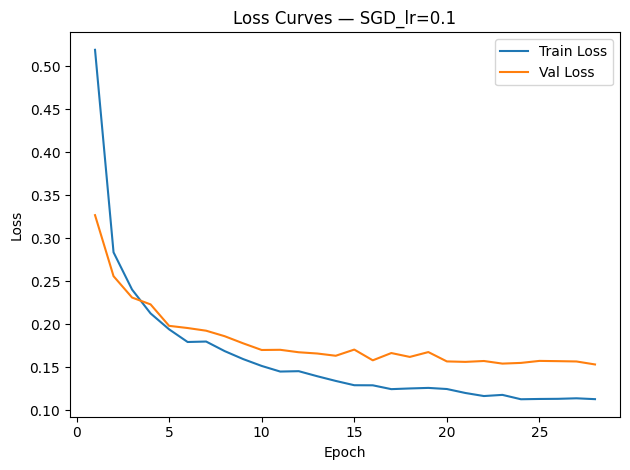

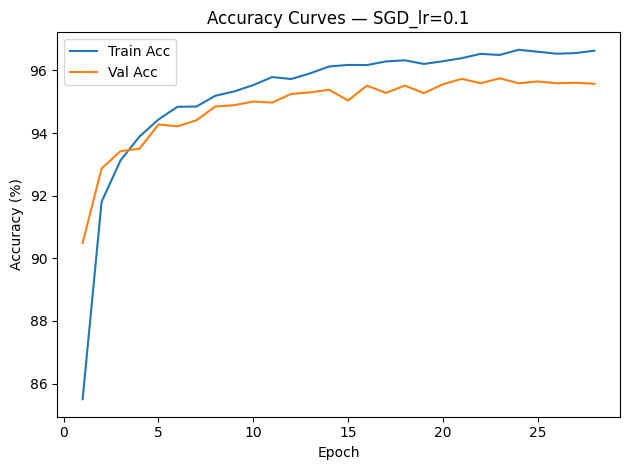

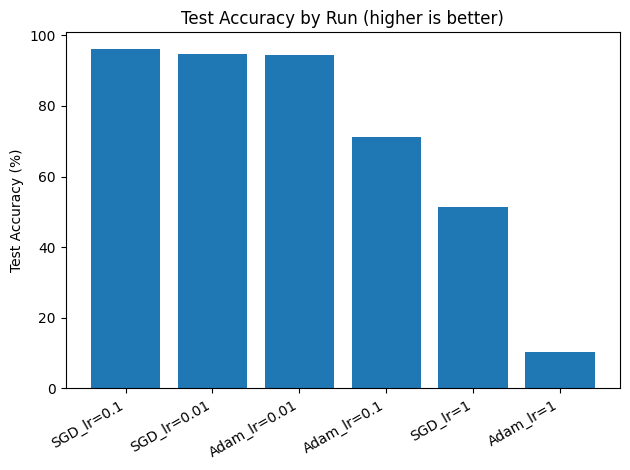

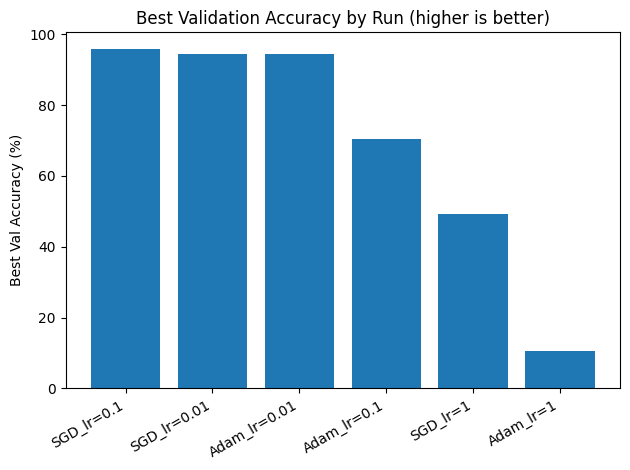

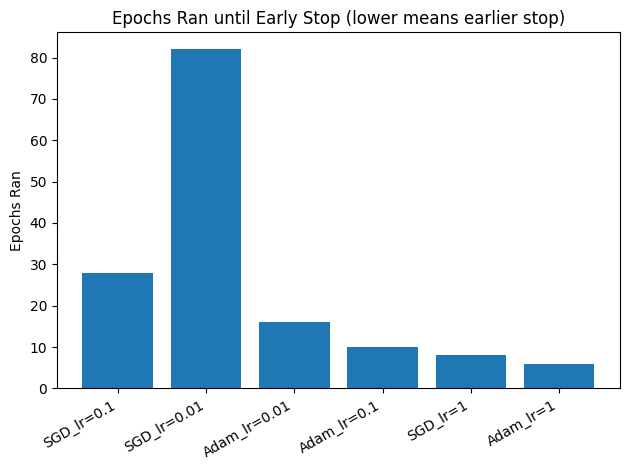

,run_key,optimizer,lr,best_val_acc(%),best_epoch,epochs_ran,test_acc(%),test_error(%),test_loss
0,SGD_lr=0.1,SGD,0.10,95.750000,23,28,96.02,3.98,0.139542
1,SGD_lr=0.01,SGD,0.01,94.308333,77,82,94.56,5.44,0.189720
2,Adam_lr=0.01,Adam,0.01,94.291667,11,16,94.30,5.70,0.203755
3,Adam_lr=0.1,Adam,0.10,70.350000,5,10,71.32,28.68,1.066062
4,SGD_lr=1,SGD,1.00,49.308333,3,8,51.45,48.55,1.250679
5,Adam_lr=1,Adam,1.00,10.458333,1,6,10.28,89.72,2.352128


In [ ]:
# ========== 可视化 results 的通用脚本（基于你已有的 results 结构） ==========

import matplotlib.pyplot as plt          # 导入 Matplotlib 的 pyplot 接口
from collections import OrderedDict      # 排序时可用（非必须）
import math                              # 计算行列数（可选）
import pandas as pd                      # 输出表格（可选但强烈建议）

# ---------- 1) 工具函数：画单个实验（key）对应的训练/验证曲线 ----------

def plot_run_curves(results, key):
    """给定 results 和某个 key，画出该实验的 Loss/Accuracy 曲线。"""
    hist = results[key]                                            # 取出该实验的历史记录字典
    epochs = range(1, len(hist["val_losses"]) + 1)                 # x 轴为 1..T 的 epoch 序列

    # Loss 曲线
    plt.figure()                                                   # 新建一张图（避免叠到上一张）
    plt.plot(epochs, hist["train_losses"], label="Train Loss")     # 训练损失曲线
    plt.plot(epochs, hist["val_losses"],   label="Val Loss")       # 验证损失曲线
    plt.xlabel("Epoch")                                            # 横轴标签
    plt.ylabel("Loss")                                             # 纵轴标签
    plt.title(f"Loss Curves — {key}")                              # 标题：标明是哪次实验
    plt.legend()                                                   # 图例
    plt.tight_layout()                                             # 紧凑布局
    plt.show()                                                     # 显示图像

    # Accuracy 曲线
    plt.figure()                                                   # 新建一张图（分开显示）
    plt.plot(epochs, hist["train_accuracies"], label="Train Acc")  # 训练准确率曲线（单位：%）
    plt.plot(epochs, hist["val_accuracies"],   label="Val Acc")    # 验证准确率曲线（单位：%）
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curves — {key}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 2) 工具函数：汇总条形图（所有组合一起比较） ----------

def plot_summary_bars(results):
    """对所有实验组合，画 Test Accuracy、Best Val Accuracy、Epochs Ran 的汇总条形图。"""
    # 先按 “验证集最佳准确率” 从高到低排序，便于比较
    keys_sorted = sorted(results.keys(),
                         key=lambda k: results[k]["best_val_accuracy"],
                         reverse=True)

    test_accs   = [results[k]["test_accuracy"]      for k in keys_sorted]   # 测试准确率（%）
    best_vals   = [results[k]["best_val_accuracy"]  for k in keys_sorted]   # 验证集最佳准确率（%）
    epochs_ran  = [results[k]["epochs_ran"]         for k in keys_sorted]   # 实际训练到的 epoch 数
    labels      = keys_sorted                                                # x 轴刻度标签

    # 图1：Test Accuracy（%）
    plt.figure()
    plt.bar(range(len(labels)), test_accs)                                   # 条形图：高度=测试准确率
    plt.xticks(range(len(labels)), labels, rotation=30, ha="right")          # x 轴刻度旋转，避免遮挡
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy by Run (higher is better)")
    plt.tight_layout()
    plt.show()

    # 图2：Best Val Accuracy（%）
    plt.figure()
    plt.bar(range(len(labels)), best_vals)
    plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
    plt.ylabel("Best Val Accuracy (%)")
    plt.title("Best Validation Accuracy by Run (higher is better)")
    plt.tight_layout()
    plt.show()

    # 图3：Epochs Ran（越小代表越早停）
    plt.figure()
    plt.bar(range(len(labels)), epochs_ran)
    plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
    plt.ylabel("Epochs Ran")
    plt.title("Epochs Ran until Early Stop (lower means earlier stop)")
    plt.tight_layout()
    plt.show()

# ---------- 3) 结果表格：便于写报告/复制 ----------

def make_results_dataframe(results):
    """把 results 汇总成 DataFrame，包含关键指标，按最佳验证准确率降序。"""
    rows = []                                                                 # 用列表累积每行
    for k, hist in results.items():                                           # 遍历所有实验组合
        # 从 key 拆解出优化器与学习率（你的 key 形式是 'Adam_lr=0.01'）
        if "_lr=" in k:
            opt_name, lr_str = k.split("_lr=")
            lr_val = float(lr_str)
        else:
            opt_name, lr_val = k, None

        rows.append({
            "run_key":           k,                                           # 组合标识
            "optimizer":         opt_name,                                    # 优化器名
            "lr":                lr_val,                                      # 学习率
            "best_val_acc(%)":   hist.get("best_val_accuracy", float("nan")), # 验证集最佳准确率
            "best_epoch":        hist.get("best_epoch", 0),                   # 最佳出现的 epoch
            "epochs_ran":        hist.get("epochs_ran", 0),                   # 实际训练轮数（含早停）
            "test_acc(%)":       hist.get("test_accuracy", float("nan")),     # 测试集准确率
            "test_error(%)":     100.0 - hist.get("test_accuracy", 0.0),      # 测试误差 = 100 - 准确率
            "test_loss":         hist.get("test_loss", float("nan")),         # 测试损失
        })

    df = pd.DataFrame(rows)                                                   # 生成 DataFrame
    df = df.sort_values(by="best_val_acc(%)", ascending=False).reset_index(drop=True)  # 按验证最佳降序
    return df

# ---------- 4) 调用：画单条曲线 / 画汇总 / 打印表格 ----------

# (A) 如果你想看某个 key 的详细曲线，把 key 改成你要看的那条，例如 "Adam_lr=0.01"
example_key = max(results, key=lambda k: results[k]["best_val_accuracy"])     # 自动选验证最佳的组合
print("Example run for curves:", example_key)                                  # 打印一下我们要画的 key
plot_run_curves(results, example_key)                                          # 画该组合的曲线

# (B) 画所有组合的汇总条形图
plot_summary_bars(results)

# (C) 打印一个整洁的 DataFrame，便于粘贴到报告
df_results = make_results_dataframe(results)
display(df_results)                                                            # 在 Jupyter/Colab 中直观显示
# 如果不是在笔记本环境，也可以用 print(df_results.to_string(index=False))
